<a href="https://colab.research.google.com/github/mjgpinheiro/AI-Strategies-StockMarket/blob/master/ML_LogRegMod1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[*********************100%***********************]  1 of 1 completed
Accuracy: 0.4881516587677725
Best hyperparameters: {'C': 0.001}
Best score: 0.5076367389060887
[*********************100%***********************]  1 of 1 completed


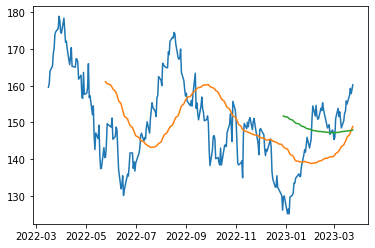

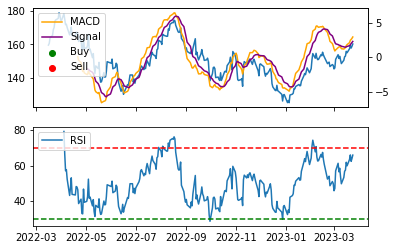

In [9]:
#!pip uninstall ta
!pip install ta

import yfinance as yf
import numpy as np
import pandas as pd
#from ta.momentum import RSIIndicator, MACD
#from ta.momentum import RSIIndicator, macd
from ta.trend import MACD

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Download data
data = yf.download('AAPL', start='2019-01-01', end='2023-03-27')
prices = data['Close']
volumes = data['Volume']

# Calculate RSI and MACD
rsi = RSIIndicator(prices, window=14)
macd = MACD(prices)

# Split data into training and testing sets
train_prices, test_prices, train_volumes, test_volumes = train_test_split(prices, volumes, test_size=0.2, train_size=0.8)

# Train logistic regression model
clf = LogisticRegression()
clf.fit(np.column_stack((train_prices[:-1], train_volumes[:-1])), np.sign(np.diff(train_prices)))

# Make predictions on test set
test_preds = clf.predict(np.column_stack((test_prices[:-1], test_volumes[:-1])))

# Calculate accuracy
accuracy = np.sum(test_preds == np.sign(np.diff(test_prices))) / (len(test_preds) - 1)
print(f"Accuracy: {accuracy}")

# Perform hyperparameter tuning using cross-validation
params = {'C': [0.001, 0.01, 0.1, 1, 10]}
clf_cv = LogisticRegression()
grid_search = GridSearchCV(clf_cv, params, cv=5, scoring='accuracy')
grid_search.fit(np.column_stack((train_prices[:-1], train_volumes[:-1])), np.sign(np.diff(train_prices)))
print(f"Best hyperparameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

def predict(prices, volumes):
    # Combine prices and volumes into a single dataset
    data = np.column_stack((prices, volumes))

    # Split data into training and testing sets
    train_data = data[:-7]
    test_data = data[-7:]

    # Scale the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_data[:-1])
    y_train = np.sign(np.diff(train_data[:, 0]))

    # Use grid search to find the best hyperparameters
    param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
    grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5)
    grid_search.fit(X_train, y_train)
    best_C = grid_search.best_params_['C']

    # Train the model using the best hyperparameters
    model = LogisticRegression(C=best_C)
    model.fit(X_train, y_train)

    # Make prediction
    X_test = scaler.transform(test_data[:-1])
    y_pred = model.predict(X_test)

    # Convert the outcome to "buy", "sell", or "hold"
    predictions = []
    for i in range(len(y_pred)):
        if y_pred[i] > 0:
            predictions.append("buy")
        elif y_pred[i] < 0:
            predictions.append("sell")
        else:
            predictions.append("hold")

    return predictions


data = yf.download('AAPL', start='2022-03-16', end='2023-03-27')
prices = data['Close']
volumes =data['Volume']

# Calculate RSI and MACD
rsi = RSIIndicator(prices, window=14)
macd = MACD(prices, window_slow=26, window_fast=12, window_sign=9)

# Extract RSI and MACD values
rsi_values = rsi.rsi()
macd_values = macd.macd()
signal_values = macd.macd_signal()

# Compute moving averages
ma_50 = prices.rolling(window=50).mean()
ma_200 = prices.rolling(window=200).mean()

# Identify buy and sell signals
buy_signals = []
sell_signals = []
for i in range(1, len(prices)):
# Buy signal: RSI below 30 and MACD crosses signal from below
  if rsi_values[i] < 30 and macd_values[i] > signal_values[i] and macd_values[i-1] <= signal_values[i-1]:
    buy_signals.append(i)
# Sell signal: RSI above 70 and MACD crosses signal from above
  elif rsi_values[i] > 70 and macd_values[i] < signal_values[i] and macd_values[i-1] >= signal_values[i-1]:
    sell_signals.append(i)

# Plot prices and moving averages
plt.plot(prices.index, prices, label='Price')
plt.plot(ma_50.index, ma_50, label='50-day MA')
plt.plot(ma_200.index, ma_200, label='200-day MA')

# Plot RSI and MACD
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
ax1.plot(prices.index, prices, label='Price')
ax2.plot(rsi_values.index, rsi_values, label='RSI')
ax2.axhline(y=30, linestyle='--', color='green')
ax2.axhline(y=70, linestyle='--', color='red')
ax2.legend(loc='upper left')
ax3 = ax1.twinx()
ax3.plot(macd_values.index, macd_values, label='MACD', color='orange')
ax3.plot(signal_values.index, signal_values, label='Signal', color='purple')
ax3.legend(loc='upper right')

# Plot buy and sell signals
plt.scatter(prices.index[buy_signals], prices[buy_signals], color='green', label='Buy')
plt.scatter(prices.index[sell_signals], prices[sell_signals], color='red', label='Sell')
plt.legend()

# Show the plots
plt.show()
